In [20]:
# note Grakel does not seem to support Python >=3.10, Python 3.9 works fine
# you are free to remove imports that are not useful for you

#import sys
#!{sys.executable} -m pip install sympy
#!{sys.executable} -m pip install matplotlib
from grakel.datasets import fetch_dataset
from grakel.kernels import WeisfeilerLehman, VertexHistogram
from sklearn.model_selection import train_test_split,cross_val_score
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn.decomposition import KernelPCA # to check your own implementation
from sklearn.manifold import TSNE
from matplotlib import pyplot as plot
import numpy as np
import scipy
import matplotlib.pyplot as plt
import math

In [21]:
# Some datasets, more datasets here https://ls11-www.cs.tu-dortmund.de/staff/morris/graphkerneldatasets
"""
    The MUTAG dataset consists of 188 chemical compounds divided into two 
    classes according to their mutagenic effect on a bacterium. 

    The chemical data was obtained form http://cdb.ics.uci.edu and converted 
    to graphs, where vertices represent atoms and edges represent chemical 
    bonds. Explicit hydrogen atoms have been removed and vertices are labeled
    by atom type and edges by bond type (single, double, triple or aromatic).
    Chemical data was processed using the Chemistry Development Kit (v1.4).
"""

"""
    ENZYMES is a dataset of protein tertiary structures obtained from (Borgwardt et al., 2005) 
    consisting of 600 enzymes from the BRENDA enzyme database (Schomburg et al., 2004). 
    In this case the task is to correctly assign each enzyme to one of the 6 EC top-level 
    classes. 
"""

"""
    NCI1 and NCI109 represent two balanced subsets of datasets of chemical compounds screened 
    for activity against non-small cell lung cancer and ovarian cancer cell lines respectively
    (Wale and Karypis (2006) and http://pubchem.ncbi.nlm.nih.gov).
"""

dataset = fetch_dataset("ENZYMES",verbose=False) # just replace by the name of the datasets you want "ENZYMES", "NCI1"
G = dataset.data
y = dataset.target


wl_kernel = WeisfeilerLehman(n_iter=10, base_graph_kernel=VertexHistogram)
K_train = wl_kernel.fit_transform(G)

print("Kernel matrix: ")
print(K_train)

print("Trace of the kernel matrix "+ str(np.linalg.matrix_rank(K_train)))


Kernel matrix: 
[[1279.  502.  585. ...  973.  998.  911.]
 [ 502.  569.  362. ...  591.  615.  565.]
 [ 585.  362.  791. ...  587.  678.  617.]
 ...
 [ 973.  591.  587. ... 2439. 1417. 1333.]
 [ 998.  615.  678. ... 1417. 1953. 1423.]
 [ 911.  565.  617. ... 1333. 1423. 1834.]]
Trace of the kernel matrix 595


In [22]:
def center_K(K):
    len_K = len(K)
    N1 = np.full((len_K, len_K), 1/len_K)

    return (K -(N1 @ K) - (K @ N1) + (N1 @ K @ N1))
    
center_K(K_train)

array([[ 554.78513889,   22.54847222,   65.21847222, ...,  -56.69986111,
          54.88013889,   27.49347222],
       [  22.54847222,  334.31180556,   86.98180556, ..., -193.93652778,
         -83.35652778,  -73.74319444],
       [  65.21847222,   86.98180556,  475.65180556, ..., -238.26652778,
         -60.68652778,  -62.07319444],
       ...,
       [ -56.69986111, -193.93652778, -238.26652778, ..., 1103.81513889,
         168.39513889,  144.00847222],
       [  54.88013889,  -83.35652778,  -60.68652778, ...,  168.39513889,
         790.97513889,  320.58847222],
       [  27.49347222,  -73.74319444,  -62.07319444, ...,  144.00847222,
         320.58847222,  791.20180556]])

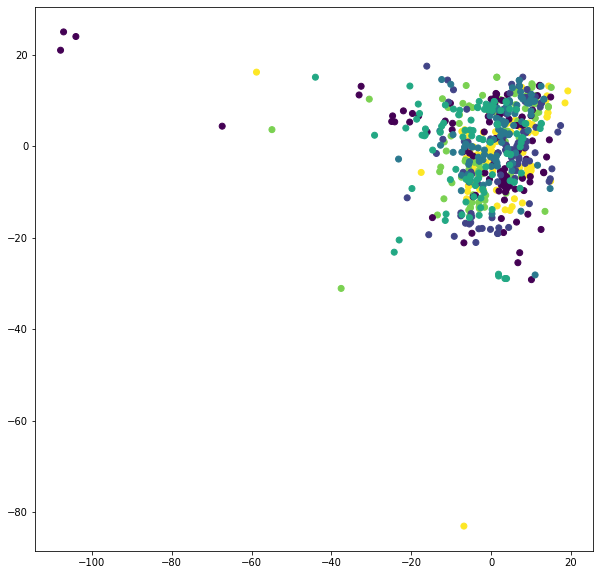

In [23]:
def display_3D(data):
    """display in a 3 dimensionnal space list of observations based on 3 coords
    """
    data = np.transpose(data)
    fig = plt.figure()
    plot_3D = fig.add_subplot(111, projection='3d')
    plot_3D.scatter(data[0],data[1],data[2], c=y)
    plt.show()
    return

def display_2D(data):
    """display in a 2 dimensionnal space list of observations based on 2 coords
    """
    data = np.transpose(data)
    fig = plt.figure(figsize=(10,10))
    plot_2D = fig.add_subplot(111)
    plot_2D.scatter(data[0],data[1], c=y)
    plt.show()
    return



def kernel_PCA(K, dim):
    """Compute the KPCA of the kernel K to the dimension dim
    ----------------------
    K: Matrix kernel used to compute the KPCA
    dim: dimension of the new space
    ----------------------
    return: the new coords of the sample based on the new dim
    """
    vals, vecs = np.linalg.eig(K)
    #skipy give same but swapped 
    vecs = np.transpose(vecs)

    # sort these based on the eigenvalues
    vecs = np.flip(vecs[np.argsort(vals)],0)[:dim]
    vals = np.flip(vals[np.argsort(vals)],0)[:dim]

    for i in range(dim):
        vecs[i] = (vecs[i] / np.sqrt(vals[i]))

    feature_space = []
    for i in range(len(K)):
        new_coord = []
        for coord in range(dim):
            new_coord.append(K[:,i]@vecs[coord])
            
        feature_space.append(new_coord)

    return np.real(feature_space)


result_KPCA = kernel_PCA(center_K(K_train), 2)
display_2D(result_KPCA)
    

In [24]:
def pairwise_dist(K):    
    dist=np.empty((len(K),len(K)))
    for i in range(len(K)):
        for j in range(len(K)):
            
            dist[i][j] = np.sqrt((K[i][i] + K[j][j] -2*K[i][j]))

    return dist


pairwise_dist(K_train)

array([[ 0.        , 29.05167809, 30.        , ..., 42.09513036,
        35.15679166, 35.93048845],
       [29.05167809,  0.        , 25.21904043, ..., 42.73172124,
        35.94440151, 35.67912555],
       [30.        , 25.21904043,  0.        , ..., 45.3431362 ,
        37.25587202, 37.2961124 ],
       ...,
       [42.09513036, 42.73172124, 45.3431362 , ...,  0.        ,
        39.47150871, 40.08740451],
       [35.15679166, 35.94440151, 37.25587202, ..., 39.47150871,
         0.        , 30.6757233 ],
       [35.93048845, 35.67912555, 37.2961124 , ..., 40.08740451,
        30.6757233 ,  0.        ]])

c:\Users\Pierre\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\manifold\_t_sne.py:691: FutureWarning: 'square_distances' has been introduced in 0.24 to help phase out legacy squaring behavior. The 'legacy' setting will be removed in 1.1 (renaming of 0.26), and the default setting will be changed to True. In 1.3, 'square_distances' will be removed altogether, and distances will be squared by default. Set 'square_distances'=True to silence this warning.
  warnings.warn(


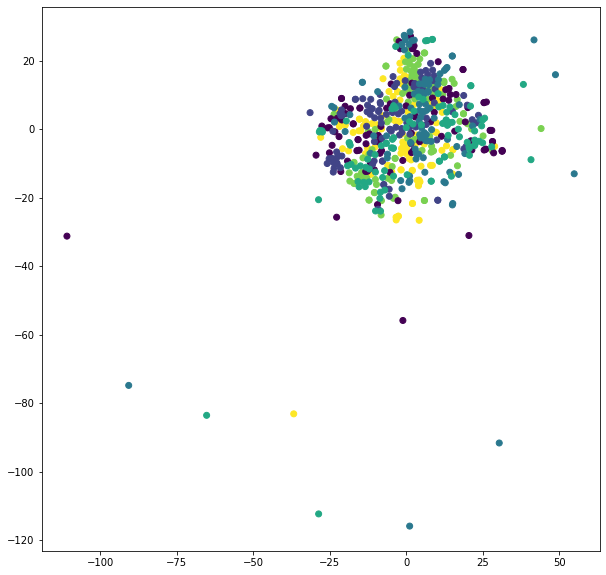

In [25]:
def tsne():

    model = TSNE(n_components=2, random_state=0, metric='precomputed')
    coords = model.fit_transform(pairwise_dist(K_train))
    display_2D(coords)
tsne()

In [26]:
from collections import Counter

def constant_model_accuracy():
    test_list = Counter(y)

    res = test_list.most_common(1)
    return res[0][1] / len(y)

constant_model_accuracy()

0.16666666666666666

In [27]:
def SVM(seta, target, risk, H):

    G_train, G_test, y_train, y_test =  train_test_split(seta, target, test_size=0.2, random_state=42)

    clf = SVC(C=risk,kernel='precomputed')

    wl_kernel_2 = WeisfeilerLehman(n_iter= H, base_graph_kernel=VertexHistogram)
    Trained = wl_kernel_2.fit_transform(G_train)
    #print(type(Trained))

    G_test_transformed = wl_kernel_2.transform(G_test)

    clf.fit(Trained, y_train)
    predicted = clf.predict(G_test_transformed)
    
    return clf.score(G_test_transformed, y_test)
    #return accuracy_score(predicted, y_test)

print(SVM(G,y,0.1,1))




0.43333333333333335


In [28]:
C= [10**-5 , 10**-4 , 10**-3 , 10**-2 , 10**-1 , 10 , 10**1 , 10**2 , 10**3 , 10**4]
H= [1,2,3,4,5,6,7,8,9,10]

def Select_hyperparameters(seta , target , C , H):
    matrix = np.zeros((len(C),len(H)))
    
    for i in range (len(C)):
        for j in range (len(H)):
            
            matrix[i][j] = np.around(SVM(seta,target,C[i],H[j]),3)
    return matrix
    
matrix_result = Select_hyperparameters(G,y,C,H)
display(np.matrix(matrix_result))

KeyboardInterrupt: 

In [29]:
C= [10**-5 , 10**-4 , 10**-3 , 10**-2 , 10**-1 , 10 , 10**1 , 10**2 , 10**3 , 10**4]
H= [1,2,3,4,5,6,7,8,9,10]

def Select_hyperparameters2(seta , target , C , H):
    matrix = np.zeros((len(C),len(H)))

    G_train, _, y_train, _ =  train_test_split(seta, target, test_size=0.2, random_state=42)
    
    for i in range (len(C)):

        print(i)
        clf = SVC(C=C[i],kernel='precomputed')
        
        
        for j in range (len(H)):
            
            
            #Train the kernel
            wl_kernel_2 = WeisfeilerLehman(n_iter= H[j], base_graph_kernel=VertexHistogram)
            Trained = wl_kernel_2.fit_transform(G_train)

            #Cross ealuate the model with the hyperparameters C and using the training set 
            scores = cross_val_score(clf, Trained, y_train, cv=10)
            matrix[i][j] = np.mean(scores)
            
            
    return matrix
    
matrix_result = Select_hyperparameters2(G,y,C,H)
display(np.matrix(matrix_result))

0


In [ ]:
print(matrix_result.max())
index = np.where(matrix_result == matrix_result.max())

for i in range (len(index[0])):
    print("combination of C = %f and H = %d give value %f which is maximum" %(C[index[0][i]], H[index[1][i]], matrix_result.max()) )
    

0.8666666666666668
combination of C = 0.001000 and H = 2 give value 0.866667 which is maximum
